## Stereo Geometry

In [1]:
%matplotlib widget

import matplotlib.pyplot as plt
from utils import *
from stereo_utils import *

### Define Camera Configuration

First we setup the environment where there is a world point and two cameras placed at an angle facing the point

In [2]:
# define parameters for the image plane
f = 2
img_size = (5, 5)

# Define camera 1 configuration

# rotate the camera first at an angle of 90 along the Y axis, then rotate it
# at an angle of 30 along the negative Z-axis
angles = [np.pi/2, -np.pi/6]
order = 'yz'
# translate the camera by an offset
offset1 = np.array([0, -10, 0])

# create rotation transformation matrix
R1 = create_rotation_transformation_matrix(angles, order)
R1_ = np.identity(4)
R1_[:3, :3] = R1
# create translation transformation matrix
T1_ = create_translation_matrix(offset1)

# Define camera 2 configuration and repeat the same steps

angles = [np.pi/2, np.pi/6]
order = 'yz'
offset2 = np.array([0, 10, 0])

R2 = create_rotation_transformation_matrix(angles, order)
R2_ = np.identity(4)
R2_[:3, :3] = R2
T2_ = create_translation_matrix(offset2)

### Plot the environment

Plot the entire setup including the cameras, the world point, the image planes of the cameras, and the intersection points.

In [4]:
# define a world point
point = np.array([[-6, 5, 2]])

In [5]:
# create and transform camera 1
xx1, yy1, Z1 = create_image_grid(f, img_size)
pt1_h = convert_grid_to_homogeneous(xx1, yy1, Z1, img_size)
pt1_h_transformed = T1_ @ R1_ @ pt1_h
xxt1, yyt1, Zt1 = convert_homogeneous_to_grid(pt1_h_transformed, img_size)

# create and transform camera 2
xx2, yy2, Z2 = create_image_grid(f, img_size)
pt2_h = convert_grid_to_homogeneous(xx2, yy2, Z2, img_size)
pt2_h_transformed = T2_ @ R2_ @ pt2_h
xxt2, yyt2, Zt2 = convert_homogeneous_to_grid(pt2_h_transformed, img_size)

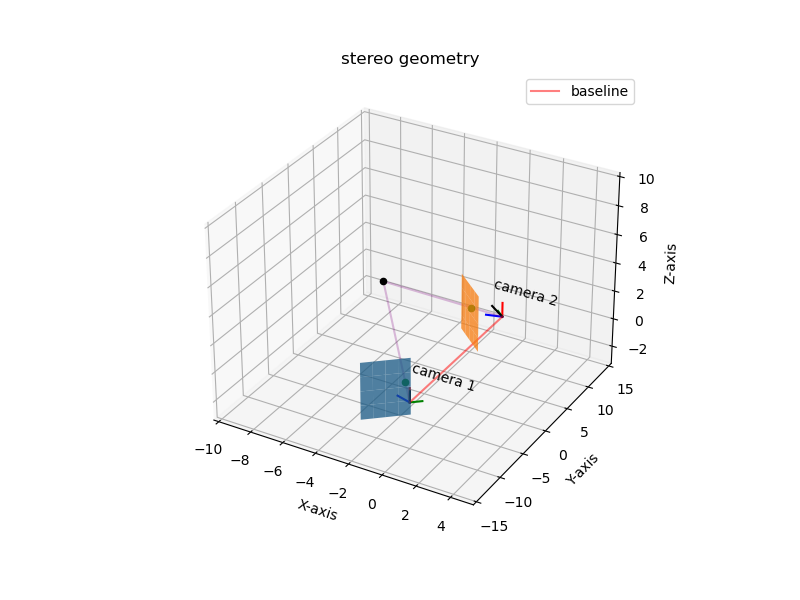

In [6]:
# define axis and figure
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111,projection='3d')

# set limits
ax.set(xlim=(-10, 5), ylim=(-15, 15), zlim=(-3, 10))

# plot both the camera centers
ax = pr.plot_basis(ax, R1, offset1, label="camera 1")
ax = pr.plot_basis(ax, R2, offset2, label="camera 2")

# plot both the image planes
ax.plot_surface(xxt1, yyt1, Zt1, alpha=0.75)
ax.plot_surface(xxt2, yyt2, Zt2, alpha=0.75)

# plot baseline
ax.plot(*make_line(offset1, offset2), color="red", alpha=0.5, label="baseline")

# plot the world point
ax.scatter(*point[0], color="black")
ax.plot(*make_line(point, offset1), color="purple", alpha=0.25)
ax.plot(*make_line(point, offset2), color="purple", alpha=0.25)

# intersection points (manually computed with trial and error)
c1_intn_world = offset1 + (point[0] - offset1) * 0.16
ax.scatter(*c1_intn_world, color="green")
c2_intn_world = offset2 + (point[0] - offset2) * 0.26
ax.scatter(*c2_intn_world, color="green")

ax.set_title("stereo geometry")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")

plt.legend()

### Computing projection of the point on the cameras

In [7]:
# create a simple camera intrinsic matrix with focal length f 
# and use it for both the cameras
K = compute_intrinsic_parameter_matrix(f, 0, 1, 0, 0)

# create the projection matrix and compute the projection of the world point for both the cameras

# compute projection for camera 1
E1 = np.linalg.inv(T1_ @ R1_)
E1_ = E1[:-1, :]
M1 = K @ E1_

proj_point1 = compute_world2img_projection(point.reshape(3, -1), M1, is_homogeneous=False)

# compute projection for camera 2
E2 = np.linalg.inv(T2_ @ R2_)
E2_ = E2[:-1, :]
M2 = K @ E2_

proj_point2 = compute_world2img_projection(point.reshape(3, -1), M2, is_homogeneous=False)

### Plot the projection of the point for both the cameras

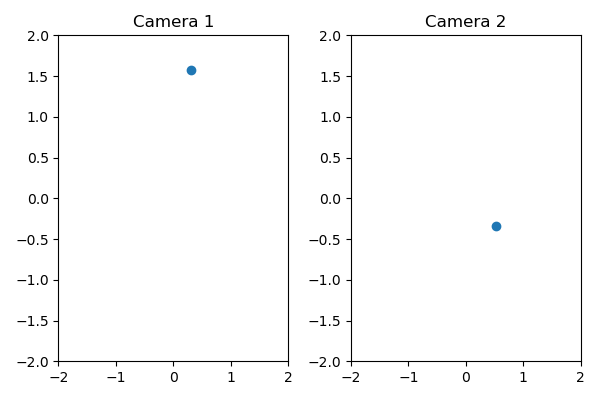

In [8]:
h, w = img_size
nrows = 1
ncols = 2

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6, 4))

# plot projection for camera 1
ax1 = axes[0]
ax1.set(xlim = (-(h // 2), w // 2), ylim = (-(h // 2), w // 2))
ax1.set_title("Camera 1")
ax1.scatter(*proj_point1.reshape(-1))

# plot projection for camera 2
ax2 = axes[1]
ax2.set(xlim = (-(h // 2), w // 2), ylim = (-(h // 2), w // 2))
ax2.set_title("Camera 2")
ax2.scatter(*proj_point2.reshape(-1))

plt.tight_layout()

## The Essential Matrix

In [11]:
# convert the world point to homogeneous coords
point_hg = to_hg_coords(point.T)

##### compute the coordinates of the world point wrt both the cameras

In [14]:
point_c1 = E1_ @ point_hg # coordinates of the point wrt camera 1
print("coordinates of the point wrt camera 1:", "\n", point_c1, "\n")
point_c2 = E2_ @ point_hg # coordinates of the point wrt camera 2
print("coordinates of the point wrt camera 2:", "\n", point_c2)

coordinates of the point wrt camera 1: 
 [[ 2.        ]
 [ 9.99038106]
 [12.69615242]] 

coordinates of the point wrt camera 2: 
 [[ 2.        ]
 [-1.33012702]
 [ 7.69615242]]


##### get change of basis matrix from camera 1 to camera 2

In [15]:
Ec = (E2 @ np.linalg.inv(E1))[:-1, :]

# extract rotation and translation matrix from the overall change of basis matrix
Rc = Ec[:, :-1]
Tc = Ec[:, -1]

In [16]:
# validate the rotation and transalation change of basis matrices
is_vectors_close(point_c2.reshape(-1), Rc @ point_c1.reshape(-1) + Tc)

In [17]:
Tm = get_cross_product_matrix(Tc)
essential_matrix = Tm @ Rc

In [18]:
point_c2.T @ essential_matrix @ point_c1

array([[-2.84217094e-14]])

In [19]:
# check p2.T @ E @ p1 = 0 
is_vectors_close(point_c2.T @ essential_matrix @ point_c1, np.array([[0]]))

In [34]:
# convert the intersection points' coordinates from world system to camera system

# convert the intersection points to homogeneous coordinates
c1_intn_world_hg = to_hg_coords(np.expand_dims(c1_intn_world, axis=1))
c2_intn_world_hg = to_hg_coords(np.expand_dims(c2_intn_world, axis=1))

# compute the coordinates of the intersection points wrt the camera
c1_intn_hg = E1 @ c1_intn_world_hg
c2_intn_hg = E2 @ c2_intn_world_hg

# convert back to euclidean coordinates
c1_intn = c1_intn_hg[:-1, :]
c2_intn = c2_intn_hg[:-1, :]

In [35]:
# check p2_intn.T @ E @ p1_intn = 0 
is_vectors_close(c2_intn.T @ essential_matrix @ c1_intn, np.array([[0]]))

### Plot Epipolar Lines

##### Compute and plot epipolar lines in the homogeneous space

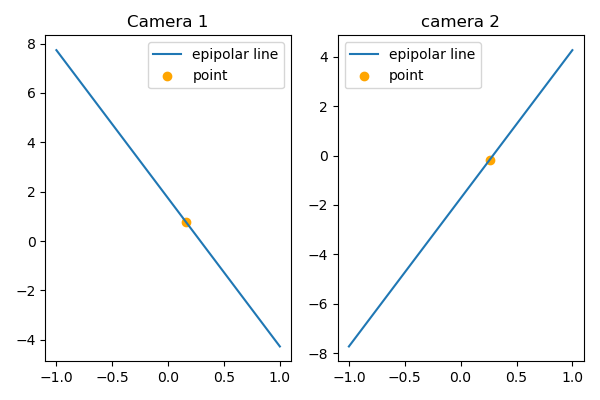

In [38]:
nrows = 1
ncols = 2

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6, 4))

# Epipolar line in camera 1 given the point wrt camera 2
ax1 = axes[0]
ax1.set_title("Camera 1")

# compute the epipolar line in camera 1
coeffs = (point_c2.T @ essential_matrix).reshape(-1)
x, y = plot_line(coeffs, (-1, 1))

# convert c2_intn from homogeneous coordinate to pixel coordinate
u, v = to_eucld_coords(c1_intn).reshape(-1)

ax1.plot(x, y, label="epipolar line")
ax1.scatter(u, v, color="orange", label="point")

# Epipolar line in camera 2 given the point wrt camera 1
ax2 = axes[1]
ax2.set_title("camera 2")

coeffs = (essential_matrix @ point_c1).reshape(-1)
x, y = plot_line(coeffs, (-1, 1))

u, v = to_eucld_coords(c2_intn).reshape(-1)

ax2.plot(x, y, label="epipolar line")
ax2.scatter(u, v, color="orange", label="point")

ax1.legend()
ax2.legend()
plt.tight_layout()

## The Fundamental Matrix

##### Compute the fundamental matrix from the essential matrix

In [39]:
fundamental_matrix =  np.linalg.inv(K).T @ essential_matrix @ np.linalg.inv(K)

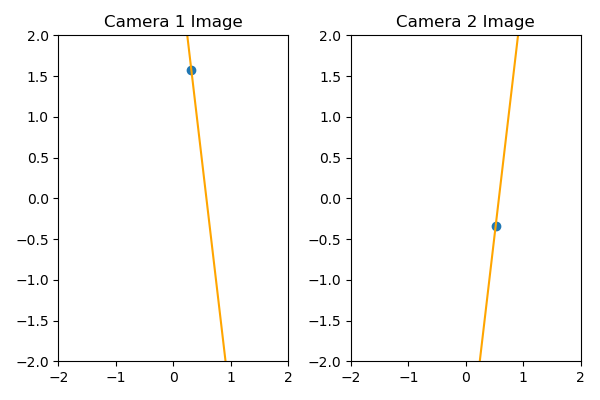

In [44]:
h, w = img_size
nrows = 1
ncols = 2

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6, 4))

# plot projection 1
ax1 = axes[0]
ax1.set(xlim = (-(h // 2), w // 2), ylim = (-(h // 2), w // 2))
ax1.set_title("Camera 1 Image")

proj_point2_hg = to_hg_coords(proj_point2)
coeffs = (proj_point2_hg.T @ fundamental_matrix).reshape(-1)
x, y = plot_line(coeffs, (-2, 2))

ax1.plot(x, y, color="orange")
ax1.scatter(*proj_point1.reshape(-1))

# plot projection 2
ax2 = axes[1]
ax2.set(xlim = (-(h // 2), w // 2), ylim = (-(h // 2), w // 2))
ax2.set_title("Camera 2 Image")

proj_point1_hg = to_hg_coords(proj_point1)
coeffs = (fundamental_matrix @ proj_point1_hg).reshape(-1)
x, y = plot_line(coeffs, (-2, 2))

ax2.plot(x, y, color="orange")
ax2.scatter(*proj_point2.reshape(-1))

plt.tight_layout()